In [2]:
%matplotlib inline

In [3]:
import numpy as np
import librosa as lb # for reference, my solutions use librosa version 0.7.2
import matplotlib.pyplot as plt
from scipy.signal import stft
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
import scipy.signal
import scipy.fftpack

In [4]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

In [5]:
def retrieveMP3s(indir):
    """
    Helper function to retrieve a list of all the .mp3 files listed in the provided directory
    
    Note: For macs, it's /*.mp3, for windows, it's \*.mp3
    
    """
    
    pathname = indir + '/*.mp3'
    
    return glob.glob(pathname)

In [6]:
def retrieveAnswer(pathname):
    """
    Helper function that takes in a .mp3 file whose name is a list of the digits spoken in the file and returns a 
    list of the characters
    
    Inputs:
    pathname - the pathname of the file of interest
    
    Outputs:
    answer - a list of the digits in the mp3's file name
    """
    basename = os.path.basename(pathname)[:-4]
    answer = [int(digit) for digit in list(basename)]
    
    return answer

In [7]:
def binToHz(k, nfft = 2048, fs = 22050):
    """
    Helper function that takes in an fft/stft frequency bin k and returns the corresponding frequency of the bin in hertz
    
    Inputs:
    k - the index of the stft row of interest
    
    Outputs:
    freq - the frequency of the provided STFT bin
    """
    
    freq = k*fs/nfft
    
    return freq

In [9]:
def hzToBin(freq, nfft = 2048, fs = 22050):
    """
    helper function that converts the provided frequency in hz to the nearest fft frequency index. Only valid for frequencies 
    contained within the first half of the fft 
    
    Inputs:
    freq - the frequency we are interested in converting to frequency index
    nfft - the size of the fft performed
    fs - the sample rate of the signal
    
    
    Outputs:
    k - converted frequency bin
    
    """
    
    k = np.round(freq*nfft/fs)
    
    return k

In [10]:
def hzToMel(hz):
    """
    Helper function that converts the provided hz frequency to mel frequency scale
    
    Inputs:
    hz - the frequency of interst in hz
    
    Outputs:
    mel - the frequency of interest in mel
    """
    
    mel = 1125*np.log(1 + hz/700)
    
    return mel

In [11]:
def melToHz(mel):
    """
    Helper function that converts the provided mel frequency to hz frequency scale
    
    Inputs:
    mel - the frequency of interest in mel
    
    Outputs:
    hz - the frequency of interst in hz
    """
    hz = 700*(np.exp(mel/1125) - 1)
    
    return hz

In [12]:
def calculateFilterMatrix(numFilters = 26, bottomFreq = 300, topFreq = 8000,  nfft = 2048):
    """
    Helper function for the MFCC calculation that returns a matrix of size numfilters x nfft//2 + 1
    """
    lowerbound = hzToMel(bottomFreq)
    upperbound = hzToMel(topFreq)
    
    freq_endpoints = melToHz(np.linspace(lowerbound, upperbound, num = numFilters + 2))
    endpoints = hzToBin(freq_endpoints)
    
    
    filterMatrix = np.zeros((numFilters, nfft//2 + 1))
    for filt in range(numFilters):
        
        #retrieve end points for use in the filter calculating function
        start = endpoints[filt]
        peak = endpoints[filt + 1]
        stop = endpoints[filt + 2]
        
        for k in range(nfft//2 + 1):
            
            if k >= start and k <= peak:
                filterMatrix[filt, k] = (k - start)/(peak - start)
            elif k >= peak and k <= stop:
                filterMatrix[filt, k] = (stop - k)/(stop - peak)
            else:
                filterMatrix[filt, k] = 0
        
    
    return filterMatrix

In [40]:
def mfcc(S, n_fft = 2048, sr = 22050, num_coeffs = 26, filterMatrix = None, bottomFreq = 300, topFreq = 8000, epsilon = 1e-9):
    """
    Performs the calculation of the MFCC feature matrix
    
    Inputs:
    
    Outputs:
    
    """
    #we begin by calculating the periodogram of the provided STFT matrix
    pxx= np.abs(S)**2/n_fft

    
    #use a precalculated filter matrix to make the calculation slightly more efficient, if desired
    if filterMatrix is not None:
        assert(num_coeffs == filterMatrix.shape[0])
        filt = filterMatrix
    else:
        filt = calculateFilterMatrix(numFilters = num_coeffs, bottomFreq = bottomFreq, topFreq = topFreq)
        
    #sum the relevant filter energies and take the logarithm of them (part of the "cepstrum calculation")
    mel_log_energies = np.log(filt@pxx + epsilon)
    
    mfcc = scipy.fftpack.dct(mel_log_energies, axis = 0, norm = 'ortho') #norm is set to ortho for the preimplemented version
    
    
    return mfcc

In [26]:
def getDigitTimes(queryName, hop_length = 128, top_db = 25):
    audio, sr = lb.core.load(queryName)
    digits = lb.effects.split(audio, hop_length = hop_length, top_db = top_db)
    
    return digits

In [15]:
def playDigits(queryName, digitTimes, hop_length=128, sr = 22050):
    
    audio, sr = lb.core.load(queryName)

    for time in digitTimes:
        ipd.display(ipd.Audio(audio[time[0]:time[1]], rate = sr))
    

In [111]:
queries = retrieveMP3s("Queries")
references = retrieveMP3s("References")

(-0.5, 1024.5, -0.5, 25.5)

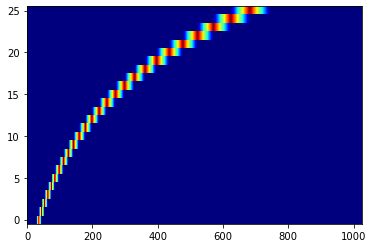

In [18]:
test = calculateFilterMatrix(numFilters = 26)
plt.imshow(test, cmap = 'jet', origin = 'lower')
plt.axis('tight')

Going to use 32834 query as a test

In [85]:
audio, sr = lb.core.load('denoisedQueries/32834_denoised.mp3', sr = 22050)

In [28]:
S = lb.core.stft(audio, n_fft = 2048, hop_length = 128)

In [35]:
digitTimes = getDigitTimes('denoisedQueries/32834_denoised.mp3')
digitTimes

array([[ 17408,  27776],
       [ 47360,  58368],
       [ 79872,  86784],
       [112128, 121984],
       [144128, 152704]])

In [32]:
playDigits('denoisedQueries/32834_denoised.mp3', digitTimes)

In [41]:
mfcc_test = mfcc(S, num_coeffs = 20)

(-0.5, 1350.5, -0.5, 19.5)

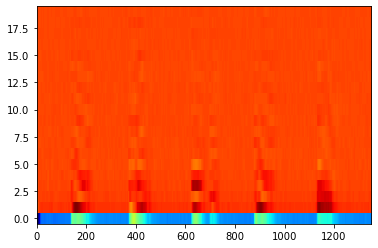

In [42]:
plt.imshow(mfcc_test, cmap = "jet", origin = "lower")
plt.axis("tight")

In [43]:
S_first = lb.core.stft(audio[17408:27776], n_fft = 2048, hop_length = 128)

In [44]:
mfcc_first = mfcc(S_first, num_coeffs = 20)

(-0.5, 81.5, -0.5, 19.5)

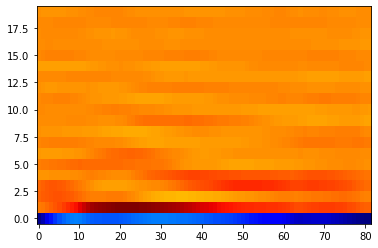

In [45]:
plt.imshow(mfcc_first, cmap = "jet", origin = "lower")
plt.axis("tight")

In [48]:
reference_three, sr = lb.core.load('References/Reference_3.mp3', sr = 22050)

In [53]:
ipd.Audio(reference_three, rate = 22050)

In [49]:
S_reference = lb.core.stft(reference_three, n_fft = 2048, hop_length = 128)

In [50]:
mfcc_ref = mfcc(S_reference, num_coeffs = 20)

(-0.5, 288.5, -0.5, 19.5)

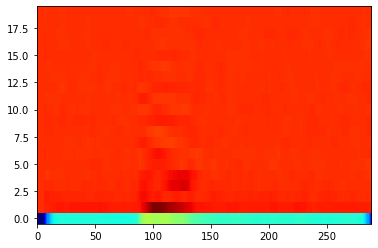

In [51]:
plt.imshow(mfcc_ref, cmap = "jet", origin = "lower")
plt.axis("tight")

In [55]:
D, wp = lb.sequence.dtw(mfcc_ref, mfcc_first)

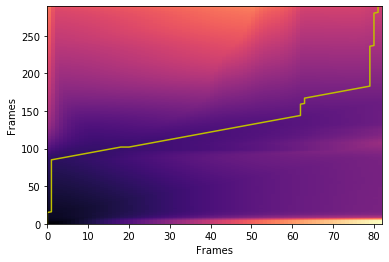

In [59]:
import librosa.display
lb.display.specshow(D, x_axis='frames', y_axis='frames')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')

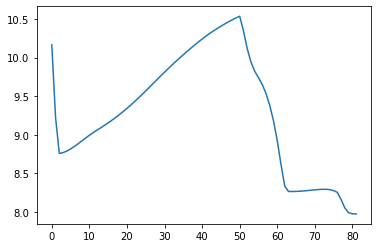

In [60]:
plt.plot(D[-1, :] / wp.shape[0])

In [62]:
np.min(D[-1,:])

2319.8407160315114

In [63]:
reference_four, sr = lb.core.load('References/Reference_4.mp3', sr = 22050)

In [64]:
S_ref4 = lb.core.stft(reference_four, n_fft = 2048, hop_length = 128)

In [68]:
mfcc_ref4 = mfcc(S_ref4, num_coeffs = 20)

In [69]:
D4, wp4 = lb.sequence.dtw(mfcc_ref4, mfcc_first)

In [70]:
np.min(D4[-1,:])

2667.1090975898137

In [71]:
print(references)

['References/Reference_4.mp3', 'References/Reference_5.mp3', 'References/Reference_7.mp3', 'References/Reference_6.mp3', 'References/Reference_2.mp3', 'References/Reference_3.mp3', 'References/Reference_1.mp3', 'References/Reference_8.mp3', 'References/Reference_9.mp3']


In [72]:
for i in range(len(references)):
    print(references[i])
    reference_num, sr = lb.core.load(references[i], sr = 22050)
    S_refNum = lb.core.stft(reference_num, n_fft = 2048, hop_length = 128)
    mfcc_refNum = mfcc(S_refNum, num_coeffs = 20)
    D_num, wp_num = lb.sequence.dtw(mfcc_refNum, mfcc_first)
    print(np.min(D_num[-1:]))

References/Reference_4.mp3
2667.10909759
References/Reference_5.mp3
2477.12735706
References/Reference_7.mp3
2836.91780188
References/Reference_6.mp3
3631.25567214
References/Reference_2.mp3
3106.45811692
References/Reference_3.mp3
2319.84071603
References/Reference_1.mp3
2492.6033046
References/Reference_8.mp3
2637.91976173
References/Reference_9.mp3
2541.94333843


In [108]:
def getMatchScores(mfccQuery, references):
    storage = []
    for i in range(len(references)):
        #print(references[i])
        reference_num, sr = lb.core.load(references[i], sr = 22050)
        S_refNum = lb.core.stft(reference_num, n_fft = 2048, hop_length = 128)
        mfcc_refNum = mfcc(S_refNum, num_coeffs = 20)
        D_num, wp_num = lb.sequence.dtw(mfcc_refNum, mfccQuery)
        storage.append(np.min(D_num[-1:]))
        #print(np.min(D_num[-1:]))
    minPos = np.argmin(storage)
    print(references[minPos])
    #return storage

In [119]:
#S_first = lb.core.stft(audio[17408:27776], n_fft = 2048, hop_length = 128, n_fft = 2048, hop_length = 128)
#answer = retrieveAnswer('Queries/32824.mp3')
def analyzeQuery(audio, times, references, originalAudio):
    answer = retrieveAnswer(originalAudio)
    
    for i in range(len(times)):
        t = times[i]
        print(answer[i])
        #print(t[0])
        #print(t[])
        S_query = lb.core.stft(audio[t[0]:t[1]], n_fft = 2048, hop_length = 128)
        mfcc_query = mfcc(S_query, num_coeffs = 20)
        getMatchScores(mfcc_query, references)


In [90]:
answer

[3, 2, 8, 2, 4]

In [120]:
analyzeQuery(audio, digitTimes, references, 'Queries/32824.mp3')

3
References/Reference_3.mp3
2
References/Reference_8.mp3
8
References/Reference_8.mp3
2
References/Reference_3.mp3
4
References/Reference_4.mp3


In [113]:
audio2, sr = lb.core.load('denoisedQueries/73914130_denoised.mp3', sr = 22050)

In [114]:
digitTimes2 = getDigitTimes('denoisedQueries/73914130_denoised.mp3')


In [116]:
playDigits('denoisedQueries/73914130_denoised.mp3', digitTimes2)

In [121]:
analyzeQuery(audio2, digitTimes2, references, 'Queries/73914130.mp3')

7
References/Reference_0.mp3
3
References/Reference_3.mp3
9
References/Reference_5.mp3
1
References/Reference_4.mp3
4
References/Reference_4.mp3
1
References/Reference_4.mp3
3
References/Reference_3.mp3
0
References/Reference_4.mp3


In [127]:
audio3, sr = lb.core.load('denoisedQueries/77777_denoised.mp3', sr = 22050)

In [123]:
digitTimes3 = getDigitTimes('denoisedQueries/77777_denoised.mp3')


In [124]:
playDigits('denoisedQueries/77777_denoised.mp3', digitTimes3)

In [125]:
analyzeQuery(audio3, digitTimes3, references, 'Queries/77777.mp3')

7
References/Reference_0.mp3
7
References/Reference_0.mp3
7
References/Reference_0.mp3
7
References/Reference_0.mp3
7
References/Reference_0.mp3


In [129]:
audio4, sr = lb.core.load('denoisedQueries/9963437165_denoised.mp3', sr = 22050)
digitTimes4 = getDigitTimes('denoisedQueries/9963437165_denoised.mp3')
playDigits('denoisedQueries/9963437165_denoised.mp3', digitTimes4)
# This has a problem since six was split in half rip

In [130]:
audio5, sr = lb.core.load('denoisedQueries/4084782589_denoised.mp3', sr = 22050)
digitTimes5 = getDigitTimes('denoisedQueries/4084782589_denoised.mp3')
playDigits('denoisedQueries/4084782589_denoised.mp3', digitTimes5)


In [131]:
analyzeQuery(audio5, digitTimes5, references, 'Queries/4084782589.mp3')

4
References/Reference_4.mp3
0
References/Reference_0.mp3
8
References/Reference_8.mp3
4
References/Reference_4.mp3
7
References/Reference_0.mp3
8
References/Reference_8.mp3
2
References/Reference_9.mp3
5
References/Reference_5.mp3
8
References/Reference_8.mp3
9
References/Reference_5.mp3


In [136]:
audio6, sr = lb.core.load('denoisedQueries/123454321_denoised.mp3', sr = 22050)
digitTimes6 = getDigitTimes('denoisedQueries/123454321_denoised.mp3')
playDigits('denoisedQueries/123454321_denoised.mp3', digitTimes6)

In [134]:
analyzeQuery(audio6, digitTimes6, references, 'Queries/123454321.mp3')

1
References/Reference_5.mp3
2
References/Reference_8.mp3
3
References/Reference_3.mp3
4
References/Reference_4.mp3
5
References/Reference_5.mp3
4
References/Reference_4.mp3
3
References/Reference_3.mp3
2
References/Reference_0.mp3
1
References/Reference_4.mp3


In [155]:
audio7, sr = lb.core.load('denoisedQueries/0123456789_denoised.mp3', sr = 22050)
digitTimes7 = getDigitTimes('denoisedQueries/0123456789_denoised.mp3')
digitTimes7 = np.delete(digitTimes7, 7, axis=0) # manually removed six that was split in half
playDigits('denoisedQueries/0123456789_denoised.mp3', digitTimes7)

In [156]:
analyzeQuery(audio7, digitTimes7, references, 'Queries/0123456789.mp3')

0
References/Reference_0.mp3
1
References/Reference_5.mp3
2
References/Reference_0.mp3
3
References/Reference_0.mp3
4
References/Reference_8.mp3
5
References/Reference_5.mp3
6
References/Reference_0.mp3
7
References/Reference_0.mp3
8
References/Reference_8.mp3
9
References/Reference_9.mp3
